In [224]:
import pandas as pd
import datetime as dt
import os
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter

In [3]:
#Cleandata
order = pd.read_csv(r"R:\NganLKT\brazilian-ecommerce\olist_orders_dataset.csv", converters={'order_purchase_timestamp': str})
payment = pd.read_csv(r"R:\NganLKT\brazilian-ecommerce\olist_order_payments_dataset.csv")
order_item = pd.read_csv(r"R:\NganLKT\brazilian-ecommerce\olist_order_items_dataset.csv")
customer_review = pd.read_csv(r"R:\NganLKT\brazilian-ecommerce\olist_order_reviews_dataset.csv")
customer_dataset = pd.read_csv(r"R:\NganLKT\brazilian-ecommerce\olist_customers_dataset.csv")

In [4]:
def date_convert(text):
#     return type(text)
    if isinstance(text,str):
        text = text.split()[0]
        text = pd.to_datetime(text)
        return text
    return None
date_convert ('10/11/2022 13:00:12')


Timestamp('2022-10-11 00:00:00')

In [5]:
order['order_purchase_timestamp'] = order['order_purchase_timestamp'].apply(date_convert)
order['order_approved_at'] = order['order_approved_at'].apply(date_convert)
order['order_delivered_carrier_date'] = order['order_delivered_carrier_date'].apply(date_convert)
order['order_delivered_customer_date'] = order['order_delivered_customer_date'].apply(date_convert)
order['order_estimated_delivery_date'] = order['order_estimated_delivery_date'].apply(date_convert)
order['Delivery time'] = (order['order_delivered_customer_date'] - order['order_purchase_timestamp'])/np.timedelta64(1, 'D')


In [6]:
new_order_dts = order[order['order_status']== 'delivered']
new_order_dts.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,Delivery time
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02,2017-10-02,2017-10-04,2017-10-10,2017-10-18,8.0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24,2018-07-26,2018-07-26,2018-08-07,2018-08-13,14.0
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08,2018-08-08,2018-08-08,2018-08-17,2018-09-04,9.0
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18,2017-11-18,2017-11-22,2017-12-02,2017-12-15,14.0
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13,2018-02-13,2018-02-14,2018-02-16,2018-02-26,3.0


In [138]:
# new_order_dts['Delivery time'] = (new_order_dts['order_delivered_customer_date'] - new_order_dts['order_purchase_timestamp'])/np.timedelta64(1, 'D')

new_order_dts['month_date'] = new_order_dts['order_purchase_timestamp'].dt.to_period('M')
new_order_dts['month_date']
#create a new df of average monthly delivery time
delivery_by_month = new_order_dts.groupby(['month_date'])['Delivery time'].mean().reset_index(name ='Delivery time')
delivery_by_month.head()
delivery_by_month = delivery_by_month.iloc[1: , :]

0        2017-10
1        2018-07
2        2018-08
3        2017-11
4        2018-02
          ...   
99436    2017-03
99437    2018-02
99438    2017-08
99439    2018-01
99440    2018-03
Name: month_date, Length: 96478, dtype: period[M]


### Demonstrate average delivery time by month

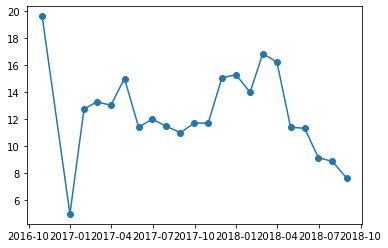

In [218]:
plt.plot_date(delivery_by_month['month_date'],delivery_by_month['Delivery time'], linestyle = 'solid' )
plt.savefig(r'R:\NganLKT\brazilian-ecommerce\Graph\delivery_date.png')

Delivery time fluctuates but in a general downward trend

### Demonstrate revenue by month


In [9]:
# process order payment file
#check if number of payment sequential equal the number of occurrence of order ID 
#>> if not equal meaning that either insufficent revenue received or missing data
# df = payment.groupby('order_id').count()
# df.groupby('payment_sequential').count()
# df = df[df['payment_sequential'] != df['count']]
# df.head()
#empty df >> correct number of sequential payment


In [10]:
# create another dataframe from payment type with sum of payment value
payment_2 = payment.groupby('order_id')['payment_value'].sum().reset_index(name ='cash_received')
payment_2.head()





,order_id,cash_received
0,00010242fe8c5a6d1ba2dd792cb16214,72.19
1,00018f77f2f0320c557190d7a144bdd3,259.83
2,000229ec398224ef6ca0657da4fc703e,216.87
3,00024acbcdf0a6daa1e931b038114c75,25.78
4,00042b26cf59d7ce69dfabb4e55b4fd9,218.04


In [11]:
#order_items
##price of each item + shipping fee
## we have to calculate the total revenue of each order ID by group the df by order ID
order_item['total_price'] = order_item['price'] + order_item['freight_value']
order_item_2 = order_item.groupby(['order_id'])['total_price'].sum().reset_index(name ='total_price_per_order')
order_item_2.head()
#merge payment with order_items

,order_id,total_price_per_order
0,00010242fe8c5a6d1ba2dd792cb16214,72.19
1,00018f77f2f0320c557190d7a144bdd3,259.83
2,000229ec398224ef6ca0657da4fc703e,216.87
3,00024acbcdf0a6daa1e931b038114c75,25.78
4,00042b26cf59d7ce69dfabb4e55b4fd9,218.04


In [12]:
#merde order item 2 with payment 2
New_1 = pd.merge(payment_2, order_item_2, how='outer', on = 'order_id')
New_1.head()
#check if money receive equal amount in order item
New_1['discrepacy']= New_1['cash_received'] - New_1['total_price_per_order']
New_2 = pd.merge(New_1,order, how = 'outer', on = 'order_id' )
New_3 = pd.merge(New_2, customer_dataset, how = 'left', on = 'customer_id' )
New_4 = pd.merge(New_3, customer_review, how = 'left', on = 'order_id')
New_4 = New_4.drop_duplicates(subset=['order_id'])
New_4.head()

,order_id,cash_received,total_price_per_order,discrepacy,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,...,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,00010242fe8c5a6d1ba2dd792cb16214,72.19,72.19,0.000000e+00,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13,2017-09-13,2017-09-19,2017-09-20,...,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ,97ca439bc427b48bc1cd7177abe71365,5,NaN,"Perfeito, produto entregue antes do combinado.",2017-09-21 00:00:00,2017-09-22 10:57:03
1,00018f77f2f0320c557190d7a144bdd3,259.83,259.83,0.000000e+00,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26,2017-04-26,2017-05-04,2017-05-12,...,eb28e67c4c0b83846050ddfb8a35d051,15775,santa fe do sul,SP,7b07bacd811c4117b742569b04ce3580,4,NaN,NaN,2017-05-13 00:00:00,2017-05-15 11:34:13
2,000229ec398224ef6ca0657da4fc703e,216.87,216.87,0.000000e+00,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14,2018-01-14,2018-01-16,2018-01-22,...,3818d81c6709e39d06b2738a8d3a2474,35661,para de minas,MG,0c5b33dea94867d1ac402749e5438e8b,5,NaN,Chegou antes do prazo previsto e o produto sur...,2018-01-23 00:00:00,2018-01-23 16:06:31
3,00024acbcdf0a6daa1e931b038114c75,25.78,25.78,0.000000e+00,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08,2018-08-08,2018-08-10,2018-08-14,...,af861d436cfc08b2c2ddefd0ba074622,12952,atibaia,SP,f4028d019cb58564807486a6aaf33817,4,NaN,NaN,2018-08-15 00:00:00,2018-08-15 16:39:01
4,00042b26cf59d7ce69dfabb4e55b4fd9,218.04,218.04,-2.842171e-14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04,2017-02-04,2017-02-16,2017-03-01,...,64b576fb70d441e8f1b2d7d446e483c5,13226,varzea paulista,SP,940144190dcba6351888cafa43f3a3a5,5,NaN,Gostei pois veio no prazo determinado .,2017-03-02 00:00:00,2017-03-03 10:54:59


In [13]:
#check for missing value
missing = pd.concat([New_4.isna().sum().sort_values(ascending = False), (New_4.isna().sum()/New_4.isna().count()*100).sort_values(ascending = False)], axis = 1, keys = ['count', 'percent']) 
missing

,count,percent
review_comment_title,87744,88.237246
review_comment_message,57886,58.211402
Delivery time,2965,2.981668
order_delivered_customer_date,2965,2.981668
order_delivered_carrier_date,1783,1.793023
discrepacy,776,0.780362
total_price_per_order,775,0.779357
order_approved_at,160,0.160899
cash_received,1,0.001006
customer_city,0,0.000000


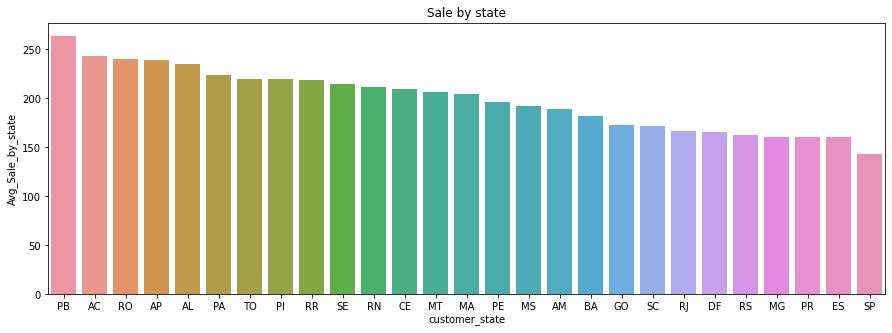

In [226]:
#Average order by state

Sale_by_state = (New_4.groupby(['customer_state'])['cash_received'].sum()/New_4.groupby('customer_state')['order_id'].count()).reset_index(name ='Avg_Sale_by_state').sort_values(ascending=False, by = 'Avg_Sale_by_state')
plt.figure(figsize=(15,5))
plt.title('Sale by state')
sns.barplot(x=Sale_by_state.customer_state, y=Sale_by_state.Avg_Sale_by_state)
plt.savefig(r'R:\NganLKT\brazilian-ecommerce\Graph\Sale_by_state.png')

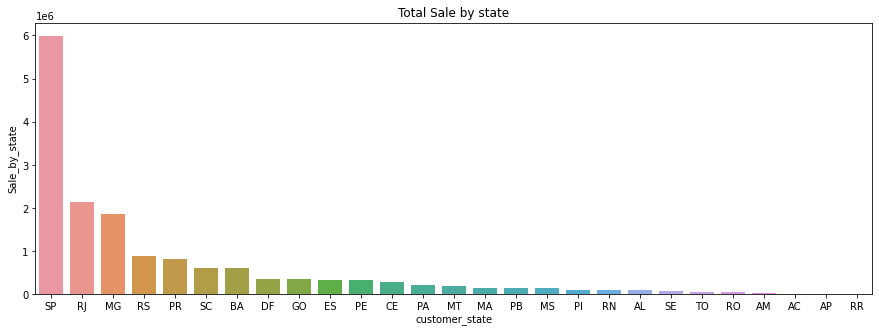

In [228]:
Total_Sale_by_state = New_4.groupby(['customer_state'])['cash_received'].sum().reset_index(name ='Sale_by_state').sort_values(ascending=False, by = 'Sale_by_state')
plt.figure(figsize=(15,5))
plt.title('Total Sale by state')
sns.barplot(x=Total_Sale_by_state.customer_state, y=Total_Sale_by_state.Sale_by_state)
plt.savefig(r'R:\NganLKT\brazilian-ecommerce\Graph\Total_Sale_by_state.png')

In [158]:
df = New_4.copy()

df['month_date'] = df['order_purchase_timestamp'].dt.to_period('M')
Monthly_sale = df.groupby(['month_date'])['total_price_per_order'].sum().reset_index(name = 'revenue')
# Monthly_sale

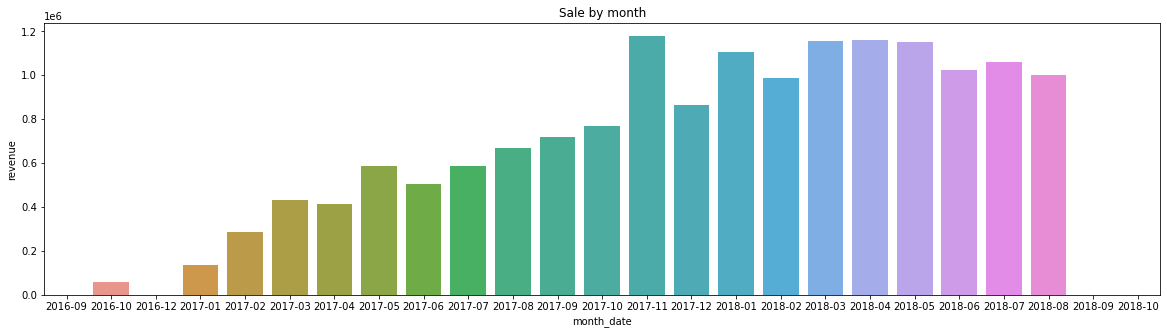

In [220]:
plt.figure(figsize=(20,5))
plt.title('Sale by month')
sns.barplot(x=Monthly_sale.month_date, y=Monthly_sale.revenue)
plt.savefig(r'R:\NganLKT\brazilian-ecommerce\Graph\monthly_sale.png')

In [230]:
New_4['cash_received'].sum()

16008872.120000001

### Check the correlation of overcharge and payment method

232 3064.7599999999998


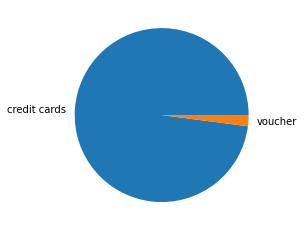

<Figure size 432x288 with 0 Axes>

In [221]:
#Check if cash receive equal total price
#receive more than actual order
df2 = New_4[New_4['discrepacy']>1]
# df4 = pd.concat([df2['discrepacy'].sum(), len(df2['discrepacy'])], axis = 1, keys = ['amount', 'number of txn'])
print(len(df2['discrepacy']), df2['discrepacy'].sum())
# print(df2['discrepacy'].sum())
#check to see the payment method
df3 = pd.merge(df2, payment, how='inner', on = 'order_id')
df3['payment_type'].value_counts()
df3['payment_installments'].value_counts()
plt.pie(df3['payment_type'].value_counts(), labels = ['credit cards', 'voucher'])


plt.show()
plt.savefig(r'R:\NganLKT\brazilian-ecommerce\Graph\overcharged.png')


**Majority of exceeded revenue is from credit card payment >> to check control system over credit payment**

In [16]:
# print(len(New_2['order_id']))
# New_3 = pd.merge(New_2, customer_review, how = 'left', on = 'order_id')
# New_3 = New_3.drop_duplicates(subset=['order_id'])
# print(len(New_3['order_id']))
# New_3
New_4.to_csv(r'R:\NganLKT\brazilian-ecommerce\mergereview.csv')

### Check for possible correlation between delivery time and review score

In [17]:
New_4.corr()

,cash_received,total_price_per_order,discrepacy,Delivery time,customer_zip_code_prefix,review_score
cash_received,1.000000,0.999987,0.017663,0.069893,0.057813,-0.050083
total_price_per_order,0.999987,1.000000,0.012543,0.069854,0.058072,-0.047508
discrepacy,0.017663,0.012543,1.000000,0.006429,0.011464,-0.004488
Delivery time,0.069893,0.069854,0.006429,1.000000,0.271432,-0.335080
customer_zip_code_prefix,0.057813,0.058072,0.011464,0.271432,1.000000,-0.015372
review_score,-0.050083,-0.047508,-0.004488,-0.335080,-0.015372,1.000000


In [18]:
#Average score >> can be improved
New_4['review_score'].mean()
    

4.0712784465160246

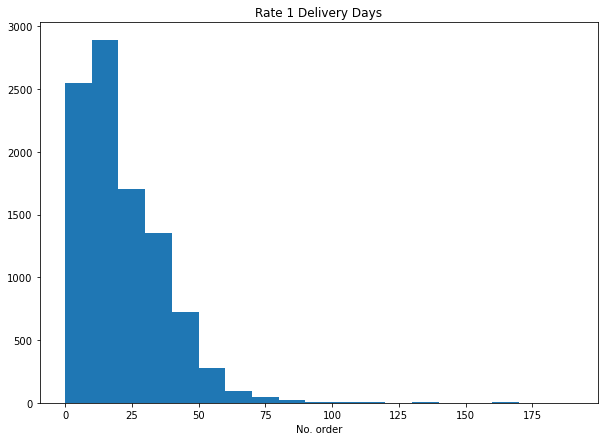

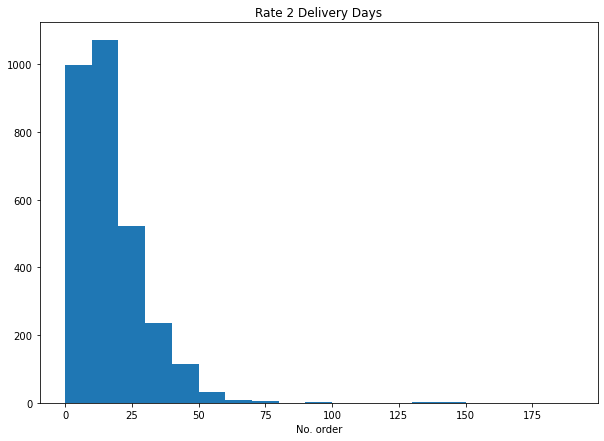

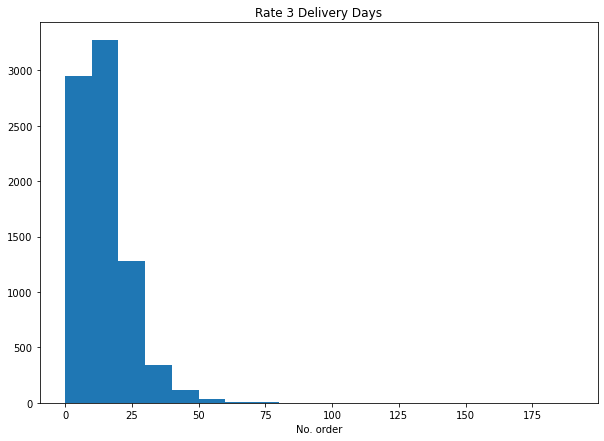

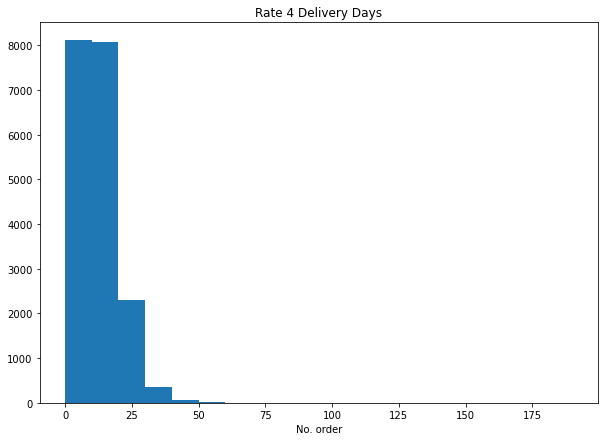

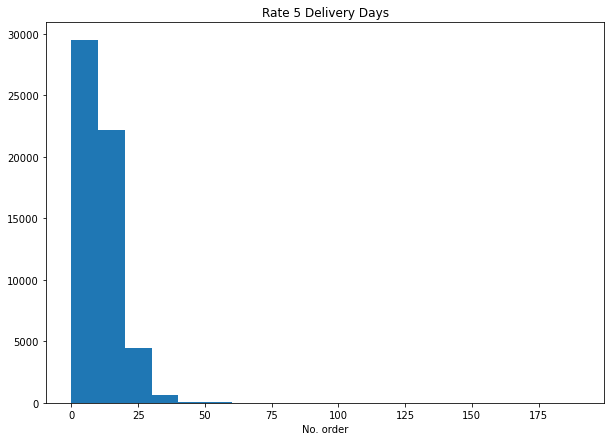

In [186]:
# fig, ax = plt.subplots(nrows=1, ncols=5)
# print(ax.shape)

for i in range(1, 6):
    Rate_1 = New_4[New_4['review_score']== i]
    fig, ax = plt.subplots(figsize =(10, 7))
    ax.hist(Rate_1['Delivery time'], bins = range(0, 200, 10))
    plt.title('Rate '+ str(i) + ' Delivery Days')
    plt.xlabel('Delivery days')
    plt.xlabel('No. order')


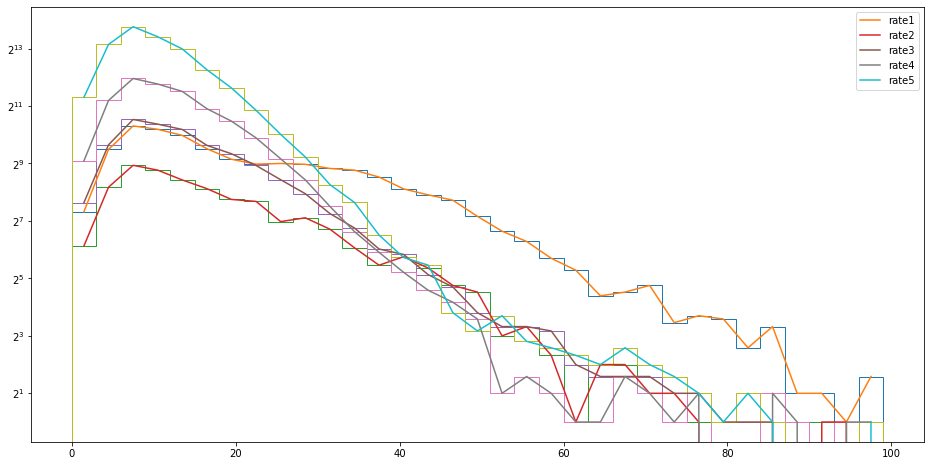

<Figure size 432x288 with 0 Axes>

In [231]:
# fig, ax = plt.subplots(nrows=1, ncols=5)
# # print(ax.shape)
# fig, ax = plt.subplots(figsize =(10, 7))
# for i in range(1, 6):
#     Rate_1 = New_4[New_4['review_score']== i]
# #     fig, ax = plt.subplots(figsize =(10, 7))
#     ax.hist(Rate_1['Delivery time'], bins = range(0, 200, 10))
#     plt.title('Rate '+ str(i) + ' Delivery Days')
#     plt.xlabel('Delivery days')
#     plt.xlabel('No. order')
# noise = np.random.normal(0,1,(1000,1))

plt.figure(figsize=(16,8))
for i in range(1, 6):
    
    Rate_1 = New_4[New_4['review_score']== i]
#     label = "rate"+ str(i)
    n,x,_ = plt.hist(Rate_1['Delivery time'], bins = range(0, 100, 3), histtype=u'step')
    bin_centers = 0.5*(x[1:]+x[:-1])
    plt.plot(bin_centers,n, label = "rate"+ str(i)) ## using bin_centers rather than edges
    plt.yscale('log', base=2)

plt.legend(loc='best')
plt.show()
plt.savefig(r'R:\NganLKT\brazilian-ecommerce\Graph\deliverytorate.png')
# plt.yscale('log', base=8)

We see a clear relation between review score and delivery time as the chart of the higher rate have higher number of shorter delivery date

### Calculate customer life time value

In [54]:
#check whether should use 'customer_id' or 'customer_unique_id'

print(New_4['customer_id'].nunique())
print(New_4['customer_unique_id'].nunique())
New_5 = New_4[New_4['order_status'] != 'canceled']
##>> use customer_unique_id

99441
96096


In [55]:
#get most recent purchase date
lastdate = max(New_5['order_purchase_timestamp'])
print(lastdate)

2018-09-03 00:00:00


In [100]:
#create a new df with frequency, gade, recency, monetary value to calculate customer value
cus_value = New_5.groupby(['customer_unique_id']).agg({'order_purchase_timestamp' : 'count', 'total_price_per_order' : 'sum'}).reset_index()
cus_value.rename(columns = {'order_purchase_timestamp':'frequency','total_price_per_order': 'total_value' }, inplace = True)
cus_value['Avg value'] = cus_value['total_value']/cus_value['frequency']
cus_value['frequency'] = cus_value['frequency'] -1

date = New_5.groupby(['customer_unique_id'])['order_purchase_timestamp'].aggregate(most_recent = 'max', most_oldest = 'min').reset_index()
date['recency'] = date['most_recent']-date['most_oldest']
date['T'] = lastdate -date['most_oldest']
date['recency'] = date['recency'].dt.days
date['T'] = date['T'].dt.days
date

# date[date['customer_unique_id']=='32ea3bdedab835c3aa6cb68ce66565ef']
# df.groupby('dummy')['returns'].agg(Mean='mean', Sum='sum')

,customer_unique_id,most_recent,most_oldest,recency,T
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10,2018-05-10,0,116
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07,2018-05-07,0,119
2,0000f46a3911fa3c0805444483337064,2017-03-10,2017-03-10,0,542
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12,2017-10-12,0,326
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14,2017-11-14,0,293
...,...,...,...,...,...
95555,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-08,2017-06-08,0,452
95556,fffea47cd6d3cc0a88bd621562a9d061,2017-12-10,2017-12-10,0,267
95557,ffff371b4d645b6ecea244b27531430a,2017-02-07,2017-02-07,0,573
95558,ffff5962728ec6157033ef9805bacc48,2018-05-02,2018-05-02,0,124


In [101]:
customer_value = pd.merge(cus_value, date, how = 'inner', on = 'customer_unique_id')
# customer_value.to_csv(r'R:\NganLKT\brazilian-ecommerce\customer_value.csv')

In [133]:
customer_value = customer_value[customer_value['Avg value'].notnull()]
customer_value = customer_value[customer_value['frequency'].notnull()]
customer_value = customer_value[(customer_value['frequency'] > 0) & (customer_value['Avg value'] > 0)]
customer_value = customer_value[customer_value['recency']!= 0]

In [136]:
bgf = BetaGeoFitter(penalizer_coef=0.000001)
bgf.fit(customer_value['frequency'], customer_value['recency'], customer_value['T'])
print(bgf)
bgf.summary

<lifetimes.BetaGeoFitter: fitted with 2090 subjects, a: 2.79, alpha: 773.55, b: 0.46, r: 7.73>


,coef,se(coef),lower 95% bound,upper 95% bound
r,7.730655,1.770303,4.260862,11.200449
alpha,773.545494,197.036029,387.354877,1159.736111
a,2.793387,0.543256,1.728606,3.858168
b,0.459345,0.099144,0.265023,0.653667


<AxesSubplot:title={'center':'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

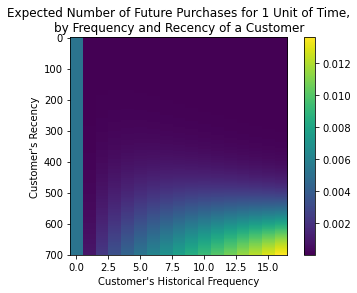

In [137]:
from lifetimes.plotting import plot_frequency_recency_matrix

plot_frequency_recency_matrix(bgf)

In [128]:
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(customer_value['frequency'],
        customer_value['Avg value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 2919 subjects, p: 8.49, q: 3.33, v: 39.73>


In [209]:
ggf.conditional_expected_average_profit(
         customer_value['frequency'],
         customer_value['Avg value']).head()

106    170.182869
124     89.119853
248     79.520957
412    115.472689
427    123.867310
dtype: float64

In [212]:
print("Expected conditional average profit: %s, Average profit: %s" % (
    ggf.conditional_expected_average_profit(
        customer_value['frequency'],
        customer_value['Avg value']
    ).mean(),
    customer_value[customer_value['frequency']>0]['Avg value'].mean()
))

Expected conditional average profit: 147.7860564521682, Average profit: 148.46504487823833
